In [1]:
import distutils.util as distutils
import os
import mujoco
import time
import itertools
import numpy as np
import matplotlib.pyplot as plt
import mediapy as media

all_variables = dir()
for name in all_variables:
    
    # Print the item if it doesn't start with '__'
    if not name.startswith('__'):
        if name == 'renderer':
            del renderer
        elif name == 'xml':
            del xml
        elif name == 'model':
            del model
        elif name == 'data':
            del data

### Introduction to Control in MuJoCo

""

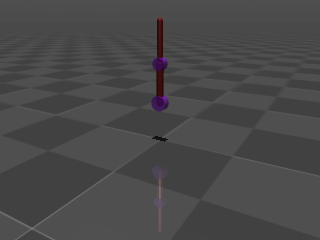

In [2]:
model = mujoco.MjModel.from_xml_path('model/Double-Pendulum/double_pendulum.xml')
data = mujoco.MjData(model)
renderer = None
renderer = mujoco.Renderer(model)
mujoco.mj_forward(model, data)
renderer.update_scene(data)
media.show_image(renderer.render())

### keyframes

""

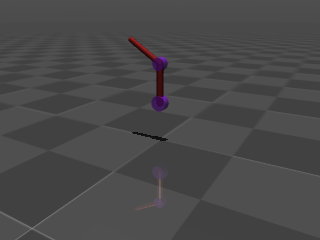

""

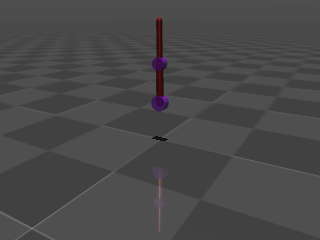

In [3]:
for key in range(model.nkey):
  mujoco.mj_resetDataKeyframe(model, data, key)
  mujoco.mj_forward(model, data)
  renderer.update_scene(data)
  media.show_image(renderer.render())

### A Gentle Introduction to Linearization in MuJoCo via LQR control of the Double Pendulum




Linearized control affine dynamics in state x and control u:
$$ x_{t+h} = Ax_t + Bu_t $$

Note that the double pendulum itself has nonlinear dynamics given by:

the two equations :

$$(m_1 + m_2) l_1 \ddot{\theta_1} + m_2 l_2 \ddot{\theta_2} \cos(\theta_1 - \theta_2) + m_2 l_2 \dot{\theta_2}^2 \sin(\theta_1 - \theta_2) + (m_1 + m_2) g \sin(\theta_1) = 0 $$

$$ m_2 l_2 \ddot{\theta_2} + m_2 l_1 \ddot{\theta_1} \cos(\theta_1 - \theta_2) - m_2 l_1 \dot{\theta_1}^2 \sin(\theta_1 - \theta_2) + m_2 g \sin(\theta_2) = 0 $$

where,

- $ m_1 $ and $ m_2 $ be the masses of the pendulum bobs.
- $ l_1 $ and $ l_2 $ be the lengths of the pendulum arms.
- $ \theta_1 $ and $ \theta_2 $ be the angles each pendulum makes with the vertical.
- $ g $ be the acceleration due to gravity.

These equations can be represented in state space form as:
$$\dot{x} = f(x,u)$$
where,

$$ x = \begin{bmatrix} \theta_1 \\ \dot{\theta_1} \\ \theta_2 \\ \dot{\theta_2} \end{bmatrix} $$

non-linear dynamics $x_{t+h} = f(x_t,u_t)$, can be *linearized* around any state-control pair. let $y=x_{t+h}$, $x=x_t$ and $u=u_t$, and using $\delta$ to mean "small change in", we can write that, recall that partial derivatives are linear operators:

$$
\delta y = \frac{\partial f}{\partial x}\delta x+ \frac{\partial f}{\partial u}\delta u
$$

In other words, the partial derivative matrices decribe a linear relationship between perturbations to state and input, and changes to the next state. Comparing to the theory of linear control affine systems, we can identify that the jacobian matrices are the transition matrices $A$ and $B$, when considering the linearized dynamical system:
$$
A = \frac{\partial f}{\partial x} \quad
B = \frac{\partial f}{\partial u}
$$

In [4]:
mujoco.mj_resetDataKeyframe(model, data, 1)
mujoco.mj_forward(model, data)
data.qacc = 0  # Assert that there is no the acceleration. to freeze the joints of the double pendulum and make it a static object.(note that the joint forces can still be computed after this assertion)
mujoco.mj_inverse(model, data)
print(data.qfrc_inverse)

[-0.24215644 -0.05159532]


### Finding the joint interaction forces to maintain keyframe pose

calculating desired forces to maintain joint pose

In [5]:
mujoco.mj_resetDataKeyframe(model, data, 1)
mujoco.mj_forward(model, data)
data.qacc = 0
qpos0 = data.qpos.copy()  # Save the position setpoint.
mujoco.mj_inverse(model, data)
qfrc0 = data.qfrc_inverse.copy()
print('desired forces:', qfrc0)

desired forces: [-0.24215644 -0.05159532]


To calculate the torques we divide with the actuator moment arms or post multiply with pseudo inverse of the actuator moment arms

In [6]:
ctrl0 = np.atleast_2d(qfrc0) @ np.linalg.pinv(data.actuator_moment)
ctrl0 = ctrl0.flatten()  # Save the ctrl setpoint.
print('control setpoint:', ctrl0)

control setpoint: [-0.05159532]


More elaborate actuators would require a different method to recover $$\frac{\partial{\texttt{qfrc\_actuator}}}{\partial{\texttt{ctrl}}}$$, and finite-differencing is always an easy option.

Let's apply these controls in the forward dynamics and compare the forces they produce with the desired forces printed above:

In [7]:
data.ctrl = ctrl0
mujoco.mj_forward(model, data)
print('actuator forces:', data.qfrc_actuator)

actuator forces: [ 0.         -0.05159532]


In [8]:
DURATION  = 3   # seconds
FRAMERATE = 60  # Hz

# Set the state and controls to their setpoints.
mujoco.mj_resetData(model, data)
data.qpos = qpos0
data.ctrl = ctrl0

camera = mujoco.MjvCamera()
mujoco.mjv_defaultFreeCamera(model, camera)
camera.distance = 2


frames = []
while data.time < DURATION:
  # Step the simulation.
  mujoco.mj_step(model, data)

  # Render and save frames.
  if len(frames) < data.time * FRAMERATE:
    # Set the lookat point to the humanoid's center of mass.
    camera.lookat = data.body('world').subtree_com
    renderer.update_scene(data, camera)
    pixels = renderer.render()
    frames.append(pixels)

media.show_video(frames, fps=FRAMERATE)

### Choosing R

In [9]:
nu = model.nu  # Alias for the number of actuators. note that this is not the number of degrees of freedom by the number of controls
R = np.eye(nu)

### Choosing Q

In [10]:
nv = model.nv  # Shortcut for the number of DoFs.

# Get the Jacobian for the root body (torso) CoM.
mujoco.mj_resetData(model, data)
data.qpos = qpos0
mujoco.mj_forward(model, data)
jac_suspension = np.zeros((3, nv))
mujoco.mj_jacSubtreeCom(model, data, jac_suspension, model.body('upper_arm').id)

# Get the Jacobian for the left foot.
jac_com = np.zeros((3, nv))
mujoco.mj_jacBodyCom(model, data, jac_com, None, model.body('forearm').id)

jac_difference = jac_suspension + jac_com
Qbalance = jac_difference.T @ jac_difference

In [11]:
# Get all joint names.
joint_names = [model.joint(i).name for i in range(model.njnt)]

# Get indices into relevant sets of joints.
body_dofs = range(0, nv)
elbow_dofs = [
    model.joint(name).dofadr[0]
    for name in joint_names
    if 'elbow' in name
]

balance_dofs = elbow_dofs
other_dofs = np.setdiff1d(body_dofs, balance_dofs)
print(balance_dofs)
print(other_dofs)

[1]
[0]


In [12]:
# Cost coefficients.
BALANCE_COST        = 1000  # Balancing.
BALANCE_JOINT_COST  = 3     # Joints required for balancing.
OTHER_JOINT_COST    = .3    # Other joints.

# Construct the Qjoint matrix.
Qjoint = np.eye(nv)
Qjoint[balance_dofs, balance_dofs] *= BALANCE_JOINT_COST
Qjoint[other_dofs, other_dofs] *= OTHER_JOINT_COST

# Construct the Q matrix for position DoFs.
Qpos = BALANCE_COST * Qbalance + Qjoint

# No explicit penalty for velocities.
Q = np.block([[Qpos, np.zeros((nv, nv))],
              [np.zeros((nv, 2*nv))]])

### Computing K

In [13]:
# Set the initial state and control.
mujoco.mj_resetData(model, data)
data.ctrl = ctrl0
data.qpos = qpos0

# Allocate the A and B matrices, compute them.
A = np.zeros((2*nv, 2*nv))
B = np.zeros((2*nv, nu))
epsilon = 1e-6
flg_centered = True
mujoco.mjd_transitionFD(model, data, epsilon, flg_centered, A, B, None, None)

In [14]:
import scipy
# Solve discrete Riccati equation.
P = scipy.linalg.solve_discrete_are(A, B, Q, R)
# Compute the feedback gain matrix K using the algebraic riccati equation.
K = np.linalg.inv(R + B.T @ P @ B) @ B.T @ P @ A

In [17]:
# Parameters.
DURATION = 5          # seconds
FRAMERATE = 60        # Hz

# Reset data, set initial pose.
mujoco.mj_resetData(model, data)
data.qpos = qpos0

# Allocate position difference dq.
dq = np.zeros(model.nv)

frames = []
while data.time < DURATION:
  # Get state difference dx.
  mujoco.mj_differentiatePos(model, dq, 1, qpos0, data.qpos)
  dx = np.hstack((dq, data.qvel)).T

  # LQR control law.
  data.ctrl = ctrl0 - K @ dx

  # Step the simulation.
  mujoco.mj_step(model, data)

  # Render and save frames.
  if len(frames) < data.time * FRAMERATE:
    renderer.update_scene(data)
    pixels = renderer.render()
    frames.append(pixels)

media.show_video(frames, fps=FRAMERATE)

In [18]:
renderer=None
# Parameters.
DURATION = 12         # seconds
FRAMERATE = 60        # Hz
TOTAL_ROTATION = 15   # degrees
CTRL_STD = 0.05       # actuator units
CTRL_RATE = 0.8       # seconds

# Make new camera, set distance.
camera = mujoco.MjvCamera()
mujoco.mjv_defaultFreeCamera(model, camera)
camera.distance = 3.3

# Enable contact force visualisation.
scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = True

# Set the scale of visualized contact forces to 1cm/N.
model.vis.map.force = 0.01

# Define smooth orbiting function.
def unit_smooth(normalised_time: float) -> float:
  return 1 - np.cos(normalised_time*2*np.pi)
def azimuth(time: float) -> float:
  return 100 + unit_smooth(data.time/DURATION) * TOTAL_ROTATION

# Precompute some noise.
np.random.seed(1)
nsteps = int(np.ceil(DURATION/model.opt.timestep))
perturb = np.random.randn(nsteps, nu)

# Smooth the noise.
width = int(nsteps * CTRL_RATE/DURATION)
kernel = np.exp(-5*np.linspace(-3, 3, width)**2)
kernel /= np.linalg.norm(kernel)
for i in range(nu):
  perturb[:, i] = np.convolve(perturb[:, i], kernel, mode='same')

# Reset data, set initial pose.
mujoco.mj_resetData(model, data)
data.qpos = qpos0

# New renderer instance with higher resolution.
renderer = mujoco.Renderer(model, width=1280, height=720)

frames = []
step = 0
while data.time < DURATION:
  # Get state difference dx.
  mujoco.mj_differentiatePos(model, dq, 1, qpos0, data.qpos)
  dx = np.hstack((dq, data.qvel)).T

  # LQR control law.
  data.ctrl = ctrl0 - K @ dx

  # Add perturbation, increment step.
  data.ctrl += CTRL_STD*perturb[step]
  step += 1

  # Step the simulation.
  mujoco.mj_step(model, data)

  # Render and save frames.
  if len(frames) < data.time * FRAMERATE:
    camera.azimuth = azimuth(data.time)
    renderer.update_scene(data, camera, scene_option)
    pixels = renderer.render()
    frames.append(pixels)

media.show_video(frames, fps=FRAMERATE)